In [42]:
from tqdm.autonotebook import tqdm
import pandas as pd
import argparse
from torch import cuda
from torch.optim import Adam
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import pdb
import ast
import numpy as np
import json
import torch
from pykeen.predict import predict_target

import matplotlib.pyplot as plt
import glob
import matplotlib as mpl
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

from PIL import ImageFilter
import matplotlib.cm as cm
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import OPTICS, Birch, AgglomerativeClustering, KMeans, AffinityPropagation, FeatureAgglomeration
from sklearn.decomposition import PCA, KernelPCA, NMF
mpl.rcParams['figure.figsize'] = (500,500)
%matplotlib inline

from PIL import Image
from warnings import simplefilter



In [4]:
model = torch.load('/opt/ml/wine/EDA/graph/RGCN_model.pkl')

In [5]:
triple = TriplesFactory.from_path_binary('/opt/ml/wine/EDA/graph/wine_triple.pt')

In [23]:
with open('/opt/ml/wine/code/feature_map/pairing2idx.json', 'r') as f: pairings = list(json.load(f).keys())

In [46]:
triple.entity_to_id

{"'A_Vita": 0,
 '0': 1,
 '00_Wines': 2,
 '1': 3,
 '10': 4,
 '100': 5,
 '1000': 6,
 '10000': 7,
 '10000_Hours': 8,
 '10001': 9,
 '10002': 10,
 '10003': 11,
 '10004': 12,
 '10005': 13,
 '10006': 14,
 '10007': 15,
 '10008': 16,
 '10009': 17,
 '1000_Stories': 18,
 '1001': 19,
 '10010': 20,
 '10011': 21,
 '10012': 22,
 '10013': 23,
 '10014': 24,
 '10015': 25,
 '10016': 26,
 '10017': 27,
 '10018': 28,
 '10019': 29,
 '1002': 30,
 '10020': 31,
 '10021': 32,
 '10022': 33,
 '10023': 34,
 '10024': 35,
 '10025': 36,
 '10026': 37,
 '10027': 38,
 '10028': 39,
 '10029': 40,
 '1003': 41,
 '10030': 42,
 '10031': 43,
 '10032': 44,
 '10033': 45,
 '10034': 46,
 '10035': 47,
 '10036': 48,
 '10037': 49,
 '10038': 50,
 '10039': 51,
 '1004': 52,
 '10040': 53,
 '10041': 54,
 '10042': 55,
 '10043': 56,
 '10044': 57,
 '10045': 58,
 '10046': 59,
 '10047': 60,
 '10048': 61,
 '10049': 62,
 '1005': 63,
 '10050': 64,
 '10051': 65,
 '10052': 66,
 '10053': 67,
 '10054': 68,
 '10055': 69,
 '10056': 70,
 '10057': 71,
 '1

In [25]:
pairings

['NaN',
 'Beef',
 'Pork',
 'Poultry',
 'Mature and hard cheese',
 'Mild and soft cheese',
 'Veal',
 'Mushrooms',
 'Sweet desserts',
 'Vegetarian',
 'Appetizers and snacks',
 'Blue cheese',
 'Rich fish (salmon, tuna etc)',
 'Shellfish',
 'Lean fish',
 'Lamb',
 'Cured Meat',
 'Game (deer, venison)',
 'Fruity desserts',
 'Spicy food',
 'Aperitif',
 'Any junk food will do',
 'Pasta',
 'Goat cheese']

In [26]:
entity_embedding = model.entity_representations[0].entity_embeddings._embeddings.weight.cpu().detach().numpy()

In [49]:
vector_dic = {}
for entity in triple.entity_to_id.keys():
    try:
        if entity.isdigit() == False:
            if entity != 'NaN' :
                vector_dic[entity] = entity_embedding[triple.entity_to_id[entity]]
    except: continue

In [43]:
class ImageCluster:
    def __init__(self, image_vectors, max_clusters : int = 5, dim_features : int = 200,
                    dim_method : str = 'kpca', cluster_method : str = 'gmm', mode = 'default',
                    resize : bool = True, size : int = 299):

        self.image_vectors = image_vectors

        self.mode = mode
        self.max_clusters = max_clusters
        self.dim_features = dim_features
        self.dim_method = dim_method
        self.cluster_method = cluster_method
        self.x = None
        self.x_done = False
        self.groups = None
        self.resize = resize
        self.size = size
        self.cluster_df = None

    def img_resize(self, img):
        org_w, org_h = img.size
        if org_w > org_h:
            resize_w = self.size
            resize_h = int((resize_w / org_w) * org_h)
        else:
            resize_h = self.size
            resize_w = int((resize_h / org_h) * org_w)
        img = img.resize((resize_w, resize_h))
        return img


    def make_cluster(self, n_cluster):
        if self.cluster_method == 'kmeans':
            clusters = KMeans(n_clusters=n_cluster, random_state=22, init='k-means++').fit(self.x)
        elif self.cluster_method == 'optics':
            clusters = OPTICS(min_samples=n_cluster).fit(self.x)
        elif self.cluster_method == 'birch':
            clusters = Birch(n_clusters=n_cluster)
        elif self.cluster_method == 'gmm':
            clusters = GaussianMixture(n_components=n_cluster).fit(self.x)
        elif self.cluster_method == 'agc':
            clusters = AgglomerativeClustering(n_clusters = n_cluster).fit(self.x)
        elif self.cluster_method == 'fagi':
            clusters = FeatureAgglomeration(n_clusters=n_cluster).fit(self.x)
        return clusters

    def dim_reduction(self):
        feat = np.array(list(self.image_vectors.values()))

        feat = feat.reshape(-1,feat.shape[-1])
        if self.dim_features != feat.shape[-1]:
          if self.dim_method == 'fagi':
              self.x = FeatureAgglomeration(n_clusters=self.dim_features).fit_transform(feat)
          elif self.dim_method == 'kpca':
              self.x  = KernelPCA(n_components=self.dim_features, random_state=1).fit_transform(feat)
          elif self.dim_method == 'isomap':
              self.x  = Isomap(n_components=self.dim_features).fit_transform(feat)
          elif self.dim_method =='LLE':
              self.x  = LocallyLinearEmbedding(n_components=self.dim_features).fit_transform(feat)
          elif self.dim_method =='SPE':
            self.x = SpectralEmbedding(n_components=self.dim_features).fit_transform(feat)
          elif self.dim_method == 'MDS':
              self.x = MDS(n_components=self.dim_features).fit_transform(feat)
        else: self.x = feat
        self.x_done = True
        return self.x

    def visualize_silhouette(self):
        self.x = self.dim_reduction()
        cluster_lists = list(range(2, self.max_clusters + 1))
        n_cols = len(cluster_lists)
      
        fig, axs = plt.subplots(figsize=(4*n_cols, 10), nrows=2, ncols=n_cols)

        for ind, n_cluster in enumerate(cluster_lists):
            clusters = self.make_cluster(n_cluster)
            cluster_labels = clusters.fit_predict(self.x)
            df = pd.DataFrame()
            groups = {}
            for i, vector in enumerate(self.x): df[i] = vector
            df = df.T
            cluster = []
            for label in cluster_labels: cluster.append(label)
            df['cluster'] = cluster
            if len(set(cluster)) == 1: continue

            sil_avg = silhouette_score(self.x, df['cluster'])
            sil_values = silhouette_samples(self.x, df['cluster'])
            y_lower = 10

            axs[0,ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                            'Silhouette Score :' + str(round(sil_avg,3)) )
            axs[0,ind].set_xlabel("The silhouette coefficient values")
            axs[0,ind].set_ylabel("Cluster label")
            axs[0,ind].set_xlim([-0.1, 1])
            axs[0,ind].set_yticks([])
            axs[0,ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])


            for i in range(n_cluster):
                ith_cluster_sil_values = sil_values[cluster_labels==i]
                ith_cluster_sil_values.sort()

                size_cluster_i = ith_cluster_sil_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_cluster)
                axs[0,ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                    facecolor=color, edgecolor=color, alpha=0.7)
                axs[0,ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))


                y_lower = y_upper + 10

                # 클러스터링된 데이터 시각화
                axs[1,ind].scatter(self.x[:, 0], self.x[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=df['cluster'])
                axs[1,ind].set_title("Clustered data")
                axs[1,ind].set_xlabel("Feature space for the 1st feature")
                axs[1,ind].set_ylabel("Feature space for the 2nd feature")

            # 군집별 중심 위치 좌표 시각화
            unique_labels = np.unique(cluster_labels)
            axs[0,ind].axvline(x=sil_avg, color="red", linestyle="--")

    def cluster(self, n_cluster):

        filenames = list(self.image_vectors.keys())
        if self.x_done:
          self.clusters = self.make_cluster(n_cluster)
          cluster_labels = self.clusters.fit_predict(self.x)
        else:
          self.x = self.dim_reduction()
          self.clusters = self.make_cluster(n_cluster)
          self.clusters.fit_predict(self.x)
          cluster_labels = self.clusters.fit_predict(self.x)

        df = pd.DataFrame()
        self.groups = {}

        for i, vector in enumerate(self.x): df[i] = vector
        df = df.T

        cluster = [label for label in cluster_labels]
        df['cluster'] = cluster
        df['filename'] = filenames

        if len(set(cluster)) == 1: pass
        sil_values = silhouette_samples(self.x, df['cluster'])
        df['silhouette_score'] = sil_values
        df= df.sort_values(['cluster', 'silhouette_score'], ascending = False)
        df = df.loc[:,['cluster','silhouette_score','filename']]

        s_threshold = df.groupby('cluster')['silhouette_score'].quantile(0.25)

        df = df[df['silhouette_score'] > 0]

        self.cluster_df = df
        self.groups = {}
        for file, cluster_label, s_value in zip(df['filename'], df['cluster'], df['silhouette_score']):
            if cluster_label not in self.groups.keys():
              self.groups[cluster_label] = []

            if (s_value > s_threshold[cluster_label]) & (s_value > 0):
                self.groups[cluster_label].append(file)

        return self.groups




In [50]:
cluster_maker = ImageCluster(image_vectors = vector_dic, dim_features=128)

/tmp/ipykernel_108554/3527054334.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  for i, vector in enumerate(self.x): df[i] = vector
/tmp/ipykernel_108554/3527054334.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  for i, vector in enumerate(self.x): df[i] = vector
/tmp/ipykernel_108554/3527054334.py:80: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To 

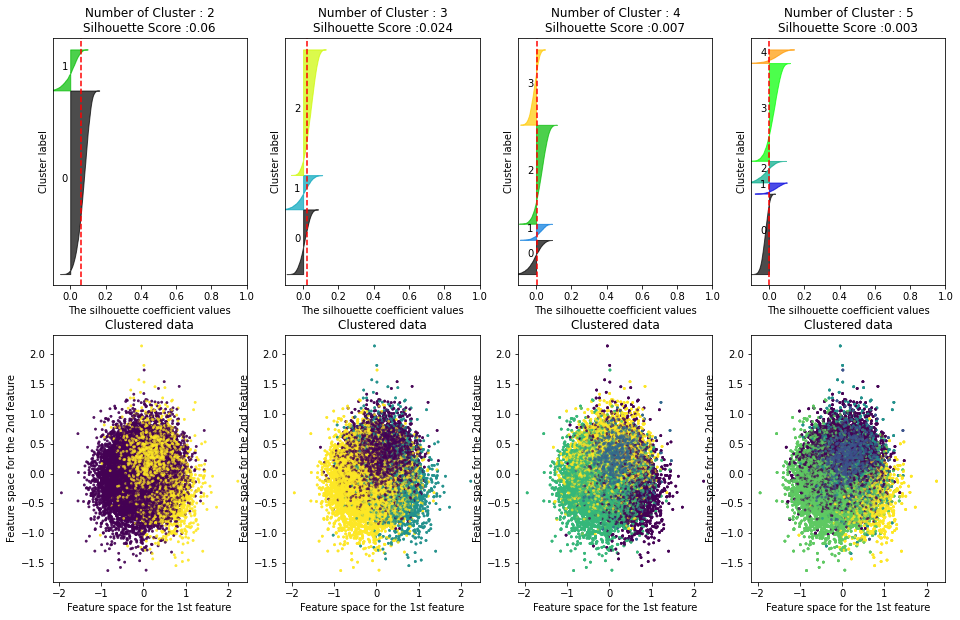

In [51]:
cluster_maker.visualize_silhouette()